In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from scripts.utils import info_map
#from scripts.arena import Arena, Aperture, Mouse, visualize_arena
from tqdm import tqdm
import os
from scipy.interpolate import interp1d
#from act_sense.scripts.optim import find_path, plot_path

BASE_PATH = "/home/rdkeller/active_sensing/act_sense/data/"

In [4]:
data = np.load("/Users/reecekeller/Documents/Xaq/act_sense/act_sense/data/info_matrix_10.0.npy")
data.shape

(60, 50)

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def find_path(data, start_x, start_y, end_x, end_y, max_steps, max_jump, weight_info, weight_acceleration, weight_steps, weight_velocity):
    # Initialize DP table and parent table
    rows, cols = data.shape
    dp = np.full((rows, cols, max_steps + 1), -np.inf)
    parent = np.full((rows, cols, max_steps + 1, 2), -1)

    # Starting point
    dp[start_x, start_y, 0] = data[start_x, start_y]

    # Define the boundaries of the localized block around the end position
    block_size = 20
    block_min_x = max(0, end_x - block_size)
    block_max_x = min(rows - 1, end_x + block_size // 2)
    block_min_y = max(0, end_y - block_size // 2)
    block_max_y = min(cols - 1, end_y + block_size // 2)

    # Fill DP table
    for k in tqdm(range(1, max_steps + 1)):
        for x in range(rows):
            for y in range(cols):
                if dp[x, y, k - 1] != -np.inf:  # Only process reachable points
                    for jump in range(1, max_jump + 1):  # Allow jumps from 1 to max_jump
                        for dx in range(-jump, jump + 1):
                            dy = jump - abs(dx)  # Remaining distance to cover
                            # Create a list of possible movements
                            possible_moves = [(dx, dy), (dx, -dy), (-dx, dy), (-dx, -dy)]

                            for dx, dy in possible_moves:
                                nx, ny = x + dx, y + dy
                                if 0 <= nx < rows and 0 <= ny < cols:
                                    # Calculate new score
                                    information_gain = weight_info * data[nx, ny]

                                    # Calculate distance moved and velocity
                                    distance_moved = np.sqrt(dx**2 + dy**2)
                                    acceleration_penalty = weight_acceleration * (distance_moved - 1) ** 2  # Penalizing acceleration

                                    # Penalize for taking steps
                                    step_penalty = weight_steps * k

                                    # Calculate velocity penalty only if within the localized block
                                    velocity_penalty = 0
                                    if block_min_x <= nx <= block_max_x and block_min_y <= ny <= block_max_y:
                                        distance_to_target = np.sqrt((end_x - nx) ** 2 + (end_y - ny) ** 2)
                                        velocity_penalty = weight_velocity * (distance_to_target)  # Encourage slower speeds near target

                                    # Combine scores
                                    new_score = dp[x, y, k - 1] + information_gain - acceleration_penalty - step_penalty - velocity_penalty

                                    # Update DP table if the new score is better
                                    if new_score > dp[nx, ny, k]:
                                        dp[nx, ny, k] = new_score
                                        parent[nx, ny, k] = [x, y]

    # Find the maximum score at the end position
    max_score = -np.inf
    best_k = -1
    for k in range(max_steps + 1):
        if dp[end_x, end_y, k] > max_score:
            max_score = dp[end_x, end_y, k]
            best_k = k

    # Reconstruct the path
    path = []
    if max_score != -np.inf:  # Only reconstruct if a valid path was found
        x, y, k = end_x, end_y, best_k
        while k >= 0:
            path.append((x, y))
            x, y = parent[x, y, k]
            k -= 1
        path.reverse()

    return path


def plot_path(data, path):
    # Plot the path if it exists
    if path:
        path_x = [point[1] for point in path]
        path_y = [point[0] for point in path]
        # Calculate speed at every point
        speeds = []
        total_distance = len(path) - 1
        for i in range(len(path)):
            if i == 0:
                speed = 0
            else:
                distance = np.sqrt((path[i][0] - path[i-1][0])**2 + (path[i][1] - path[i-1][1])**2)
                speed = distance / total_distance
            speeds.append(speed)

    # Create a subplot with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2)

    # Plot the data matrix with path overlay
    if path:
        path_x = [point[1] for point in path]
        path_y = [point[0] for point in path]
        axs[0].plot(path_x, path_y, 'r.', label = 'Path')

    # Set the size of the subplots
    fig.set_size_inches(12, 6)

    # Set the axis labels for the first plot
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    # Add a colorbar to the heatmap
    im = axs[0].imshow(data)
    fig.colorbar(im, ax=axs[0])

    # Plot speed as a function of progress
    progress = np.linspace(0, 1, len(speeds))
    axs[1].plot(progress, speeds, 'b--')
    smoothed_speeds = np.convolve(speeds, np.ones(3)/3, mode='valid')
    smoothed_progress = np.linspace(0, 1, len(smoothed_speeds))
    axs[1].plot(smoothed_progress, smoothed_speeds, 'r-')
    # Set the axis labels for the second plot
    axs[1].set_xlabel('Trial Progress')
    axs[1].set_ylabel('Speed')

    # Show the plots
    axs[0].legend(loc='upper left')
    axs[1].legend(['Speed', 'Smoothed Speed'], loc='lower right')
    plt.show()

In [157]:
# Example usage
start_x, start_y = 30, 0
end_x, end_y = 0, 49
max_steps = 100  # Example maximum number of steps
max_jump = 5  # Maximum jump distance in any direction

weight_info = 1.0
weight_acceleration = 1.0  # Weight for acceleration penalty
weight_steps = 1.0  # Step penalty weight
weight_velocity = 1.0  # Weight for velocity penalty
path = find_path(data, start_x, start_y, end_x, end_y, max_steps, max_jump, weight_info, weight_acceleration, weight_steps, weight_velocity)

if not path:
    print("No valid path found.")
else:
    print("Path found:", path)



100%|██████████| 100/100 [01:22<00:00,  1.21it/s]

Path found: [(30, 0), (30, 4), (30, 8), (30, 12), (30, 16), (30, 19), (30, 22), (29, 25), (29, 28), (28, 31), (27, 34), (26, 36), (25, 38), (24, 40), (22, 42), (19, 43), (15, 44), (11, 45), (7, 46), (3, 47), (0, 49)]


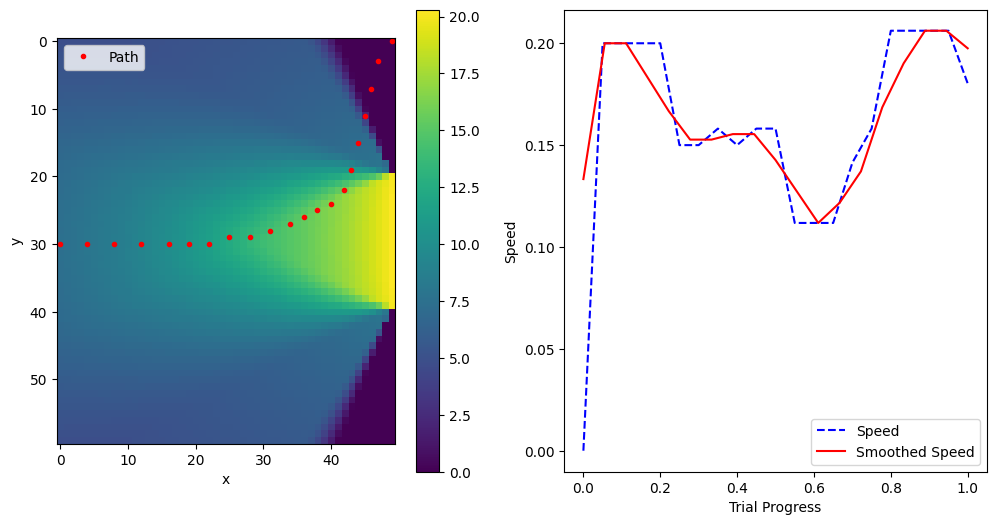

In [161]:
plot_path(data, path)